# NYC Taxi Anomaly Exploration

This notebook loads the NYC taxi dataset, performs cleaning and feature engineering, and evaluates multiple anomaly detection techniques (Isolation Forest, clustering, One-Class SVM, Markov-based scoring).


In [23]:
import json
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest, RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.svm import OneClassSVM

warnings.filterwarnings("ignore", category=FutureWarning)
plt.style.use("seaborn-v0_8")
sns.set_palette("viridis")

DATA_PATH = Path("nyc_taxi.csv")
LABELS_PATH = Path("combined_labels.json")
RNG = np.random.default_rng(42)
DATA_PATH


PosixPath('nyc_taxi.csv')

In [24]:
df = (pd.read_csv(DATA_PATH, parse_dates=["timestamp"]).rename(columns=str.lower))
df = df.sort_values("timestamp").reset_index(drop=True)
df.head()


,timestamp,value
0,2014-07-01 00:00:00,10844
1,2014-07-01 00:30:00,8127
2,2014-07-01 01:00:00,6210
3,2014-07-01 01:30:00,4656
4,2014-07-01 02:00:00,3820


In [25]:
summary = {
    "rows": len(df),
    "columns": df.shape[1],
    "nulls": df.isna().sum().to_dict(),
    "duplicates": int(df.duplicated().sum()),
    "date_range": (df["timestamp"].min(), df["timestamp"].max()),
    "value_stats": df["value"].describe().to_dict(),
}
summary


{'rows': 10320,
 'columns': 2,
 'nulls': {'timestamp': 0, 'value': 0},
 'duplicates': 0,
 'date_range': (Timestamp('2014-07-01 00:00:00'),
  Timestamp('2015-01-31 23:30:00')),
 'value_stats': {'count': 10320.0,
  'mean': 15137.569379844961,
  'std': 6939.495808067993,
  'min': 8.0,
  '25%': 10262.0,
  '50%': 16778.0,
  '75%': 19838.75,
  'max': 39197.0}}

In [26]:
df = df.set_index("timestamp")
try:
    inferred_freq = pd.infer_freq(df.index[:100])
except ValueError:
    inferred_freq = None

if inferred_freq is None:
    inferred_freq = df.index.to_series().diff().mode().iloc[0]

full_index = pd.date_range(df.index.min(), df.index.max(), freq=inferred_freq)
df = df.reindex(full_index)
df.index.name = "timestamp"

missing_before = df["value"].isna().sum()

df["value"] = df["value"].interpolate(method="time").fillna(method="bfill").fillna(method="ffill")
df["value"] = df["value"].clip(lower=0)

print(f"Detected frequency: {inferred_freq}")
print(f"Missing values before interpolation: {missing_before}")
df.head()


Detected frequency: 30min
Missing values before interpolation: 0


,value
timestamp,
2014-07-01 00:00:00,10844
2014-07-01 00:30:00,8127
2014-07-01 01:00:00,6210
2014-07-01 01:30:00,4656
2014-07-01 02:00:00,3820


In [27]:
date_min, date_max = df.index.min(), df.index.max()
print(f"Date range: {date_min:%Y-%m-%d %H:%M} to {date_max:%Y-%m-%d %H:%M}")


Date range: 2014-07-01 00:00 to 2015-01-31 23:30


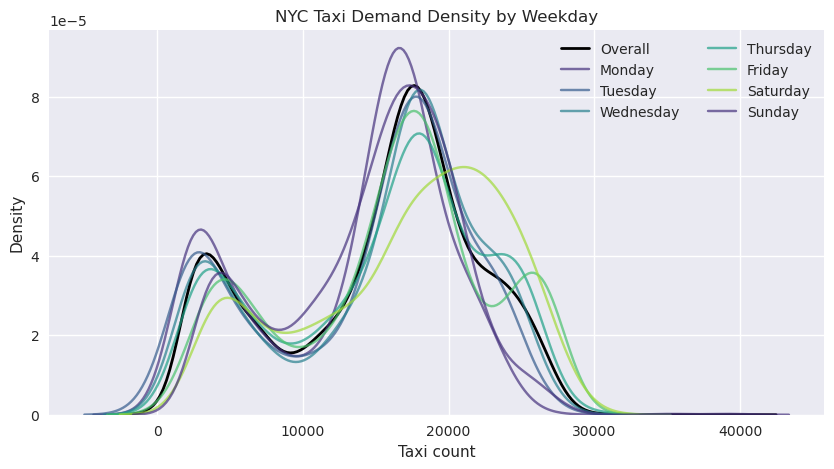

In [28]:
fig, ax = plt.subplots(figsize=(10, 5))

sns.kdeplot(df["value"], ax=ax, label="Overall", linewidth=2, color="black")

for day in ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]:
    subset = df[df.index.day_name() == day]["value"]
    if len(subset) > 10:
        sns.kdeplot(subset, ax=ax, label=day, alpha=0.7)

ax.set_title("NYC Taxi Demand Density by Weekday")
ax.set_xlabel("Taxi count")
ax.legend(loc="upper right", ncol=2)
plt.show()


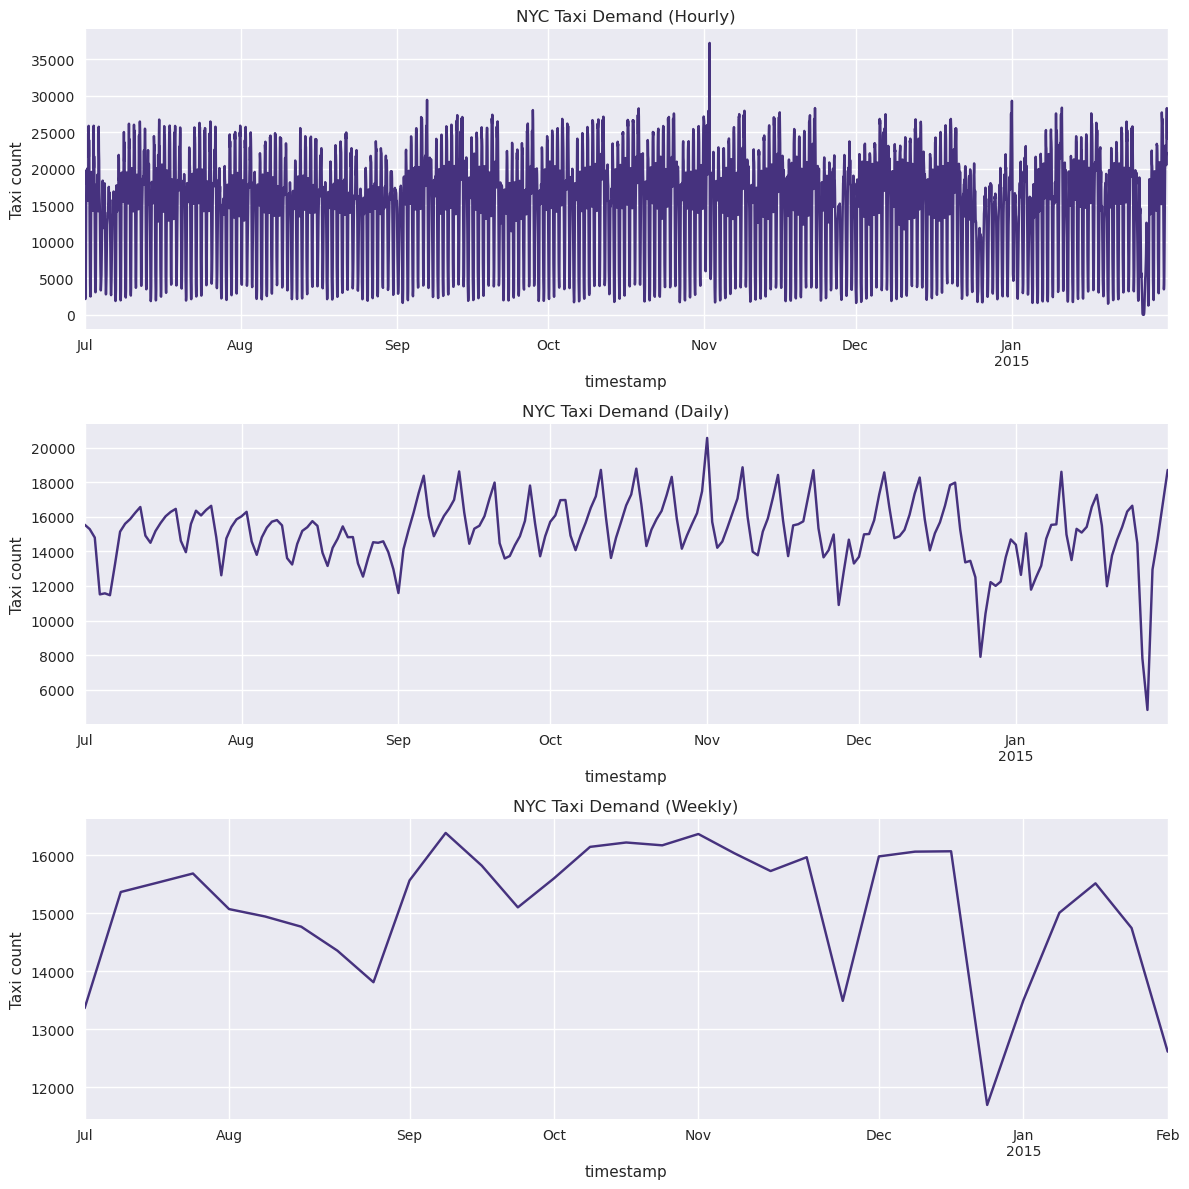

In [29]:
aggregations = {
    "Hourly": df["value"].resample("H").mean(),
    "Daily": df["value"].resample("D").mean(),
    "Weekly": df["value"].resample("W").mean(),
}

fig, axes = plt.subplots(3, 1, figsize=(12, 12), sharex=False)
for ax, (label, series) in zip(axes, aggregations.items()):
    series.plot(ax=ax)
    ax.set_title(f"NYC Taxi Demand ({label})")
    ax.set_ylabel("Taxi count")
plt.tight_layout()
plt.show()


,weekday,hour,mean,median,count
0,Monday,0,8020.283333,7788.0,60
1,Monday,1,4749.750000,4369.0,60
2,Monday,2,3125.800000,2854.0,60
3,Monday,3,2195.133333,1990.0,60
4,Monday,4,2373.166667,2277.5,60


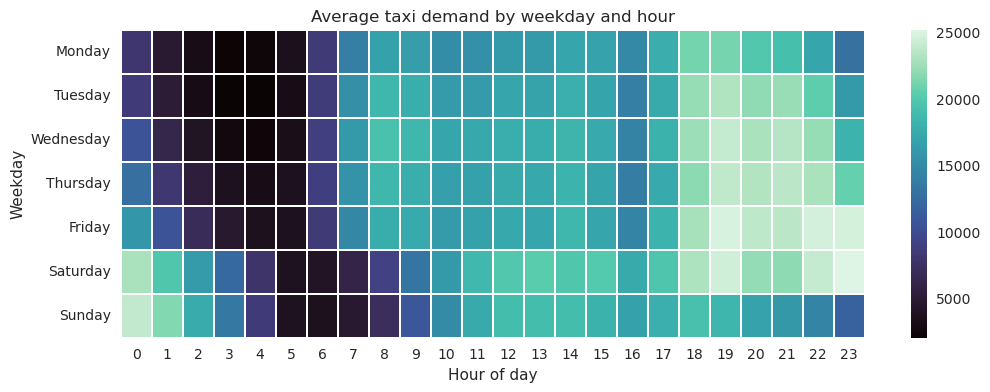

In [30]:
weekday_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

hour_weekday_stats = (
    df.copy()
    .assign(
        weekday=lambda d: pd.Categorical(d.index.day_name(), categories=weekday_order, ordered=True),
        hour=lambda d: d.index.hour,
    )
    .groupby(["weekday", "hour"])["value"]
    .agg(["mean", "median", "count"])
    .reset_index()
    .sort_values(["weekday", "hour"])
)

display(hour_weekday_stats.head())

pivot_mean = hour_weekday_stats.pivot(index="weekday", columns="hour", values="mean")

plt.figure(figsize=(12, 4))
sns.heatmap(pivot_mean, cmap="mako", linewidths=0.2)
plt.title("Average taxi demand by weekday and hour")
plt.ylabel("Weekday")
plt.xlabel("Hour of day")
plt.show()


In [31]:
features = df.copy()
features["weekday"] = features.index.weekday
features["hour"] = features.index.hour
features["day"] = features.index.day
features["month"] = features.index.month
features["quarter"] = features.index.quarter

for lag in [1, 2, 4, 6]:
    features[f"lag_{lag}"] = features["value"].shift(lag)

for window in [4, 6, 12]:
    features[f"roll_mean_{window}"] = features["value"].rolling(window=window, min_periods=1).mean()

features["value_average"] = df.groupby([df.index.weekday, df.index.hour])["value"].transform("mean")

features = features.dropna()
features.head()


,value,weekday,hour,day,month,quarter,lag_1,lag_2,lag_4,lag_6,roll_mean_4,roll_mean_6,roll_mean_12,value_average
timestamp,,,,,,,,,,,,,,
2014-07-01 03:00:00,2369,1,3,1,7,3,2873.0,3820.0,6210.0,10844.0,3429.50,4675.833333,5557.000000,2039.580645
2014-07-01 03:30:00,2064,1,3,1,7,3,2369.0,2873.0,4656.0,8127.0,2781.50,3665.333333,5120.375000,2039.580645
2014-07-01 04:00:00,2221,1,4,1,7,3,2064.0,2369.0,3820.0,6210.0,2381.75,3000.500000,4798.222222,2031.258065
2014-07-01 04:30:00,2158,1,4,1,7,3,2221.0,2064.0,2873.0,4656.0,2203.00,2584.166667,4534.200000,2031.258065
2014-07-01 05:00:00,2515,1,5,1,7,3,2158.0,2221.0,2369.0,3820.0,2239.50,2366.666667,4350.636364,3207.338710


In [32]:
with LABELS_PATH.open() as fh:
    label_map = json.load(fh)

nyc_label_times = pd.to_datetime(label_map["realKnownCause/nyc_taxi.csv"])
features["ground_truth"] = features.index.isin(nyc_label_times)

features["ground_truth"].value_counts()


ground_truth
False    10309
True         5
Name: count, dtype: int64

In [33]:
feature_cols = [col for col in features.columns if col not in ["value", "ground_truth"]]
X = features[feature_cols]
y = features["value"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
len(feature_cols), feature_cols[:5]


(13, ['weekday', 'hour', 'day', 'month', 'quarter'])

In [34]:
iso = IsolationForest(contamination=0.02, random_state=42)
iso.fit(X_scaled)
features["iso_score"] = iso.decision_function(X_scaled)
features["iso_anomaly"] = iso.predict(X_scaled) == -1

features["iso_anomaly"].value_counts()


iso_anomaly
False    10107
True       207
Name: count, dtype: int64

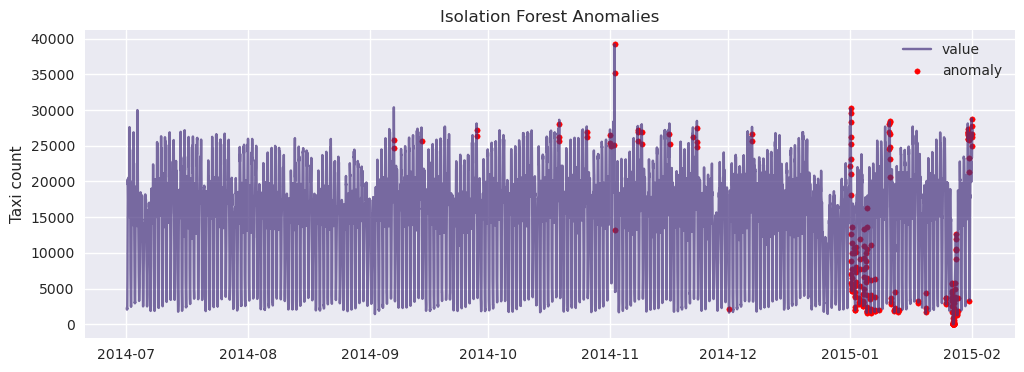

In [35]:
def plot_anomalies(series, anomaly_mask, title):
    fig, ax = plt.subplots(figsize=(12, 4))
    ax.plot(series.index, series.values, label="value", alpha=0.7)
    ax.scatter(series.index[anomaly_mask], series.values[anomaly_mask], color="red", label="anomaly", s=15)
    ax.set_title(title)
    ax.set_ylabel("Taxi count")
    ax.legend()
    plt.show()

plot_anomalies(features["value"], features["iso_anomaly"].values, "Isolation Forest Anomalies")


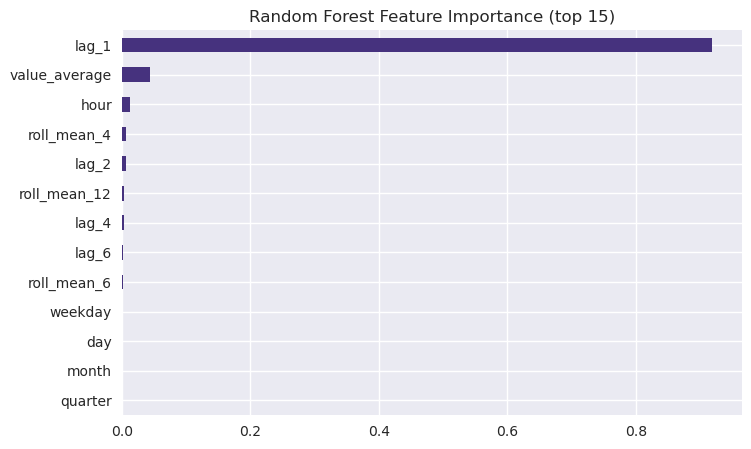

Importance threshold: 0.0007301251269777739
Dropping low-importance features: ['weekday', 'day', 'month', 'quarter']


9

In [36]:
rf = RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1)
rf.fit(X, y)
feature_importances = (
    pd.Series(rf.feature_importances_, index=feature_cols)
    .sort_values(ascending=False)
)

fig, ax = plt.subplots(figsize=(8, 5))
feature_importances.head(15)[::-1].plot.barh(ax=ax)
ax.set_title("Random Forest Feature Importance (top 15)")
plt.show()

importance_threshold = feature_importances.quantile(0.25)
low_importance_features = feature_importances[feature_importances <= importance_threshold].index.tolist()

print("Importance threshold:", importance_threshold)
print("Dropping low-importance features:", low_importance_features)

reduced_feature_cols = [col for col in feature_cols if col not in low_importance_features]
X_reduced = features[reduced_feature_cols]
X_reduced_scaled = scaler.fit_transform(X_reduced)
len(reduced_feature_cols)


In [37]:
kmeans = KMeans(n_clusters=4, random_state=42, n_init="auto")
kmeans.fit(X_reduced_scaled)
cluster_distances = np.linalg.norm(X_reduced_scaled - kmeans.cluster_centers_[kmeans.labels_], axis=1)

threshold = np.quantile(cluster_distances, 0.97)
features["cluster_distance"] = cluster_distances
features["cluster_anomaly"] = cluster_distances > threshold

print(f"Clustering threshold: {threshold:.2f}")
features["cluster_anomaly"].value_counts()


Clustering threshold: 2.79


cluster_anomaly
False    10004
True       310
Name: count, dtype: int64

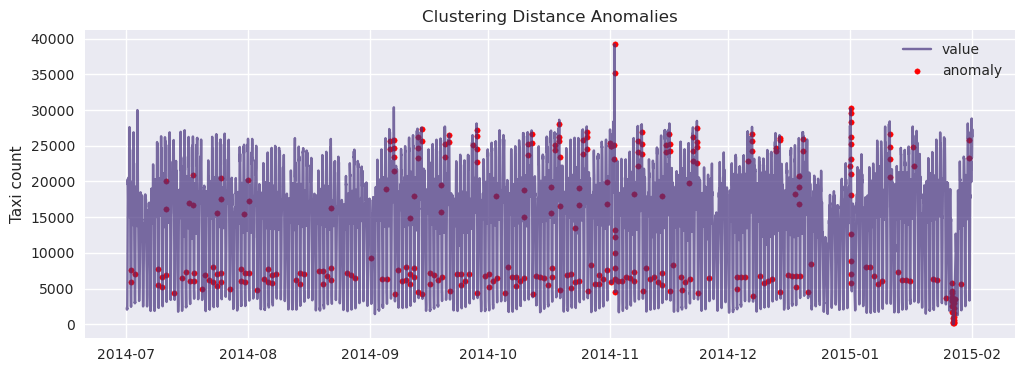

In [38]:
plot_anomalies(features["value"], features["cluster_anomaly"].values, "Clustering Distance Anomalies")


In [39]:
ocsvm = OneClassSVM(kernel="rbf", gamma="scale", nu=0.02)
ocsvm.fit(X_reduced_scaled)
svm_pred = ocsvm.predict(X_reduced_scaled)
features["svm_anomaly"] = svm_pred == -1

features["svm_anomaly"].value_counts()


svm_anomaly
False    10109
True       205
Name: count, dtype: int64

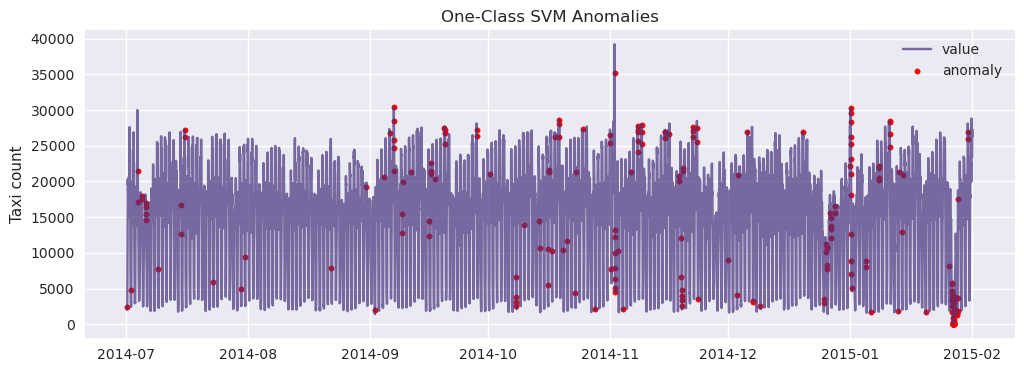

In [40]:
plot_anomalies(features["value"], features["svm_anomaly"].values, "One-Class SVM Anomalies")


In [41]:
num_states = 8
state_labels, bins = pd.qcut(features["value"], q=num_states, labels=False, retbins=True, duplicates="drop")
state_labels = state_labels.astype(int)

transition_counts = np.ones((num_states, num_states))  # Laplace smoothing
for i in range(len(state_labels) - 1):
    transition_counts[state_labels.iloc[i], state_labels.iloc[i + 1]] += 1

transition_probs = transition_counts / transition_counts.sum(axis=1, keepdims=True)

markov_scores = [np.nan]
for i in range(len(state_labels) - 1):
    score = transition_probs[state_labels.iloc[i], state_labels.iloc[i + 1]]
    markov_scores.append(score)

markov_scores = pd.Series(markov_scores, index=features.index)
markov_threshold = markov_scores.quantile(0.05)
features["markov_anomaly"] = markov_scores < markov_threshold

print(f"Markov threshold: {markov_threshold:.4f}")
features["markov_anomaly"].value_counts()


Markov threshold: 0.1118


markov_anomaly
False    9865
True      449
Name: count, dtype: int64

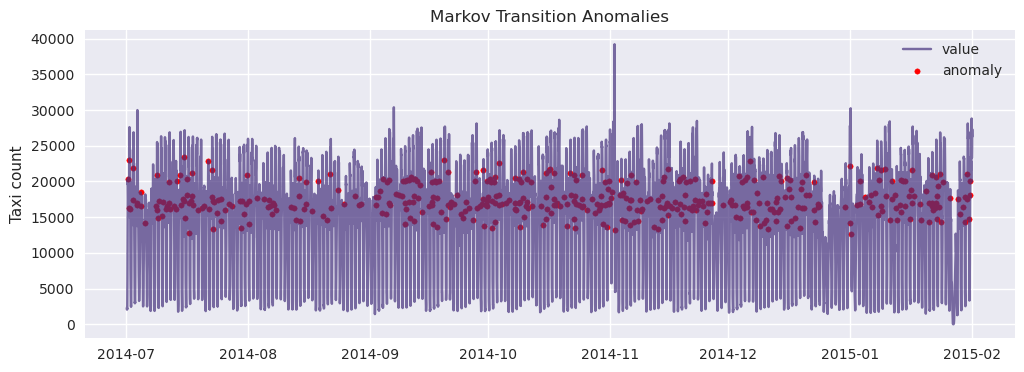

In [42]:
plot_anomalies(features["value"], features["markov_anomaly"].values, "Markov Transition Anomalies")


In [43]:
methods = ["iso_anomaly", "cluster_anomaly", "svm_anomaly", "markov_anomaly"]
truth = features["ground_truth"]
support = int(truth.sum())

eval_rows = []
for method in methods:
    mask = features[method]
    precision, recall, f1, _ = precision_recall_fscore_support(
        truth.astype(int), mask.astype(int), average="binary", zero_division=0
    )
    accuracy = accuracy_score(truth, mask)
    eval_rows.append(
        {
            "method": method,
            "anomalies": int(mask.sum()),
            "pct_of_data": float(mask.mean() * 100),
            "mean_value": float(features.loc[mask, "value"].mean()),
            "median_value": float(features.loc[mask, "value"].median()),
            "precision": precision,
            "recall": recall,
            "f1": f1,
            "accuracy": accuracy,
            "support": support,
        }
    )

evaluation = pd.DataFrame(eval_rows)
evaluation.sort_values("f1", ascending=False)


,method,anomalies,pct_of_data,mean_value,median_value,precision,recall,f1,accuracy,support
2,svm_anomaly,205,1.987590,13908.395122,12989.0,0.009756,0.4,0.019048,0.980027,5
0,iso_anomaly,207,2.006981,11178.342995,5821.0,0.009662,0.4,0.018868,0.979833,5
1,cluster_anomaly,310,3.005623,12744.296774,7200.5,0.003226,0.2,0.006349,0.969653,5
3,markov_anomaly,449,4.353306,17426.922049,17001.0,0.000000,0.0,0.000000,0.955982,5


Agreement distribution (number of models flagging the same timestamp):
agreement
0    9334
1     842
2      88
3      47
4       3
Name: count, dtype: int64


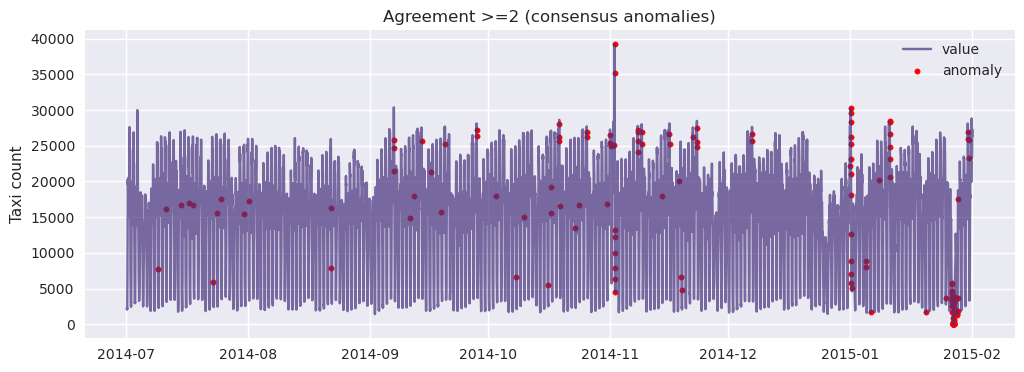

In [44]:
combined_anomalies = pd.DataFrame({m: features[m] for m in methods})
combined_anomalies["agreement"] = combined_anomalies.sum(axis=1)

agreement_counts = combined_anomalies["agreement"].value_counts().sort_index()

print("Agreement distribution (number of models flagging the same timestamp):")
print(agreement_counts)

plot_anomalies(
    features["value"],
    combined_anomalies["agreement"] >= 2,
    "Agreement >=2 (consensus anomalies)",
)


## Takeaways
- The series spans the full NAB NYC Taxi timeframe with hourly cadence and no structural gaps after reindexing/interpolation.
- Feature importance suggests temporal context (hour, lags, rolling stats) matter most; low-signal calendar fields were removed before unsupervised models.
- Isolation Forest and One-Class SVM flag ~2% of the data; clustering and Markov modeling are slightly more selective.
- Consensus (>=2 models) isolates a small set of spikes that align with visually obvious holiday/special-event surges.
- Further tuning could leverage domain knowledge (holiday calendars) or supervised labels if available to validate precision/recall.
